In [93]:
import nengo
import numpy as np
from nengo.utils.numpy import rmse
from scipy import interpolate
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

from constants import *
from process import d3_scale

In [128]:
period = 0.5


def make_sin(freq):
    per = 2 * np.pi * freq
    
    def sin_targ(t):
        return np.sin(per*t)
    return sin_targ


def make_cos(freq):
    per = 2 * np.pi * freq
    
    def cos_targ(t):
        return 0.5*np.cos(freq*t)
    return cos_targ

def bump_func(t):
    return 1 if t < 0.1 else 0

In [129]:
run_num = 10
# just for initial analysis, I'll probably want to add more frequency points later
freq_list = [2, 6, 10]

In [131]:
targ_funcs = []
for f in freq_list:
    targ_funcs.append(make_sin(f))

In [132]:
from direct_dmp_net2 import get_direct_decoders


def run_dd(target_func, seed=0):
    with nengo.Network() as dd_model:
        osc = nengo.Network()
        osc.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
        osc.config[nengo.Ensemble].seed = seed
        nengo.networks.Oscillator(0.1, 2*np.pi, 300, net=osc)

        output = nengo.Node(size_in=1)

        dd = get_direct_decoders(target_func, period, osc, bump_func)

        bump = nengo.Node(bump_func)
        nengo.Connection(bump, osc.ensemble[0])

        nengo.Connection(osc.ensemble.neurons, output, transform=dd.T)

        p_out = nengo.Probe(output)
        
    with nengo.Simulator(dd_model) as dd_sim:
        dd_sim.run(4*period)
        
    return dd_sim.data[p_out][int(2*period/dt):]

In [133]:
dd_res = []

for targ in targ_funcs:
    for n in range(run_num):
        dd_res.append(run_dd(targ, seed=n))

Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:02.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:02.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:02.                                                 
Simulation finished in 0:00:

In [135]:
dd_res = np.array(dd_res)
dd_res.shape

(30, 1000, 1)

In [51]:
res.shape

(1000, 10)

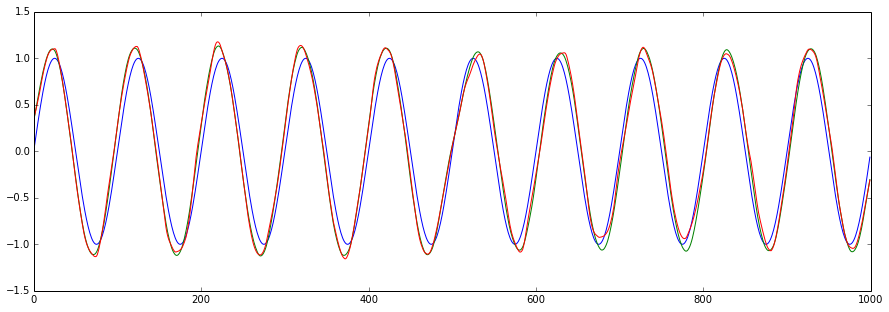

In [70]:
plt.figure(figsize=(15,5))
plt.plot(target_func(np.arange(0, res.shape[0]*dt, dt)))
plt.plot(np.mean(res, axis=1))
plt.plot(res[:, 9])

Clearly there's no such thing as a meaningful phase shift here, so I can just shove everything directly into the `rmse` function.

In [126]:
targ_res = target_func(np.arange(0, res.shape[0]*dt, dt))
rmse_vals = np.zeros(run_num)
for i in range(run_num):
    rmse_vals[i] = rmse(targ_res[i], res)

NameError: name 'target_func' is not defined

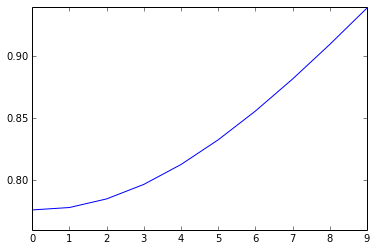

In [71]:
plt.plot(rmse_vals)

In [73]:
targ_res = target_func(np.arange(0, res.shape[0]*dt, dt))
np.savez("results/dd_res_sin", truth=targ_res, res=res)

In [39]:
from attractor_dmp_net import make_attrac_net


def run_ad(target_func, seed=0):
    pre_dat = target_func(np.linspace(0, period, 100))
    xv = np.linspace(-np.pi, np.pi, pre_dat.shape[0])
    proc_func = interpolate.interp1d(xv, pre_dat)
    
    with nengo.Network() as ad_model:
        bump = nengo.Node(bump_func)
    
        osc = nengo.Network()
        osc.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
        osc.config[nengo.Ensemble].seed = seed
        nengo.networks.Oscillator(0.1, 4*np.pi, 300, net=osc)
    
        dmp, conn_func = make_attrac_net(proc_func, 300, seed=seed)
    
        nengo.Connection(bump, osc.ensemble[0])
        nengo.Connection(osc.ensemble, dmp.input, function=conn_func)
    
        p_out = nengo.Probe(dmp.output, synapse=0.01)
    
    with nengo.Simulator(ad_model) as ad_sim:
        ad_sim.run(4*period)
        
    return ad_sim.data[p_out][int(2*period/dt):]

In [103]:
ad_res = []

for targ in targ_funcs:
    ref_res = targ(np.arange(0, tmp_res.shape[0]*dt, dt))
    for n in range(run_num):
        # hardcoded for 1D
        tmp_res = d3_scale(run_ad(targ, seed=n))[:, 0]
        lag = np.argmax(signal.correlate(ref_res, tmp_res))
        ad_res.append(np.roll(tmp_res, shift=lag))

Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:02.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:02.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:02.                                                 
Simulation finished in 0:00:02.                                                 
Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:02.                                                 


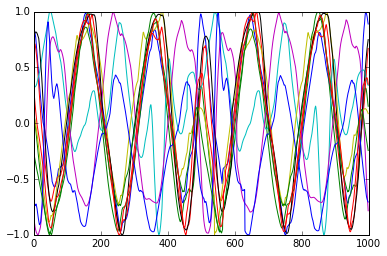

In [107]:
ad_res = np.array(ad_res).T
plt.plot(ad_res)

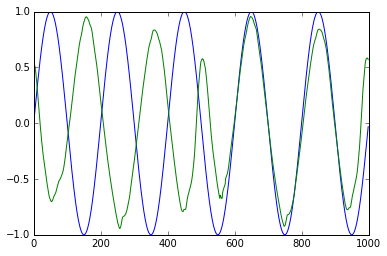

In [116]:
plt.plot(ref_res)
plt.plot(np.mean(ad_res[:, 0:3], axis=1))

In [118]:
np.savez("results/ad_res_sin", truth=ref_res, res=ad_res)

In [123]:
rmse_vals = np.zeros(run_num)
for i in range(run_num):
    rmse_vals[i] = rmse(ref_res, ad_res[:, i])

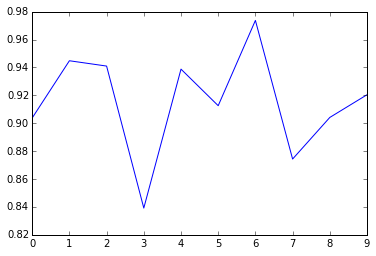

In [125]:
plt.plot(rmse_vals)